# Prepare some things
## Load some modules

In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the exposome data

In [4]:
exposome = pd.read_csv("../ExposomeChallengeData/datasets/exposome.csv", index_col=0).iloc[:,1:]
exposome.head()

h_abs_ratio_preg_Log  h_no2_ratio_preg_Log  h_pm10_ratio_preg_None  \
1              0.896711              2.872304               25.948498   
2              0.892538              2.980008               25.897739   
3              0.778723              3.056501               26.087347   
4              0.089056              3.089157               14.991380   
5              0.604781              3.848211               35.197296   

   h_pm25_ratio_preg_None  hs_no2_dy_hs_h_Log  hs_no2_wk_hs_h_Log  \
1               17.433798            2.530279            2.583284   
2               18.470850            1.928600            2.652479   
3               18.711547            2.882591            2.591756   
4               16.409771            1.390750            2.456717   
5               14.889958            3.204449            3.499594   

   hs_no2_yr_hs_h_Log  hs_pm10_dy_hs_h_None  hs_pm10_wk_hs_h_None  \
1            2.612098             22.535828             20.850005   
2            2.761064             14.077763             29.141274   
3            2.356163             46.859096             31.530981   
4            2.403247             29.817442             25.232778   
5            3.307663             29.817442             24.891465   

   hs_pm10_yr_hs_h_None  ...  hs_globalexp2_None  hs_smk_parents_None  \
1             31.399067  ...                   1                    2   
2             31.250535  ...                   0                    0   
3             27.516001  ...                   0                    1   
4             23.965263  ...                   1                    1   
5             24.754238  ...                   0                    0   

   h_distinvnear1_preg_Log  h_trafload_preg_pow1over3  \
1                -5.629052                   0.345830   
2                -5.045588                   0.345830   
3                -4.204225                 145.572759   
4                -3.088010                 187.120021   
5                -1.459250                 158.489039   

   h_trafnear_preg_pow1over3  hs_trafload_h_pow1over3  \
1                  21.213987               135.995760   
2                  22.649684                97.884416   
3                  25.549436               127.536143   
4                  22.743850               114.868483   
5                  29.872070               205.774781   

   hs_trafnear_h_pow1over3  h_bro_preg_Log  h_clf_preg_Log  h_thm_preg_Log  
1                24.914911       -2.975930       -0.536713        0.288073  
2                27.905292       -2.975930        1.078750        3.195478  
3                29.299706       -1.604450        1.188758        3.023924  
4                22.743850        2.748819        3.636813        3.839335  
5                14.131454        4.262137        3.027843        4.572734  

[5 rows x 222 columns]

And min-max normalize it

In [5]:
columns, index = exposome.columns, exposome.index
exposome = pd.DataFrame(MinMaxScaler().fit_transform(exposome))
exposome.columns, exposome.index = columns, index
exposome.head()
# Save it to CSV
exposome.to_csv("../ExposomeChallengeData/datasets/exposome_minmax.csv")

In [6]:
print("Shape of the data set:", exposome.shape)
print("Number of data points:", np.multiply(*exposome.shape))

Shape of the data set: (1152, 222)
Number of data points: 255744


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [7]:
phenotype_cat = pd.read_csv("../ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

birth_weight  iq  behaviour  asthma  bmi  cohort  age  sex  education  \
1             3   0          3       0    1       3    1    0          1   
2             3   1          3       0    1       3    2    0          2   
3             3   0          3       1    3       3    1    0          2   
4             1   2          3       0    1       1    4    1          0   
5             3   0          1       0    1       2    4    0          0   

   native  parity  
1       2       0  
2       2       1  
3       2       1  
4       2       1  
5       2       0

In [8]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


# Raw data

## K-means


Try fitting K-means with a range of clusters. Compute the silhouette as a metric of QC. Plot the results.

In [9]:
MIN_K = 2
MAX_K = 20

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(exposome)
    sils.append(sklearn.metrics.silhouette_score(exposome, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

The best result is achieved with K=2.

The categorical data has between 2 and 7 classes. I'll fix K to each number of classes and compare the clusters with the true labels to see if they match.

I'll plot a 2D representation of the data using the t-SNE transformacion with two components.

In [10]:
tsne = TSNE(n_components=2, init='pca')
raw_data_tsne = tsne.fit_transform(exposome)

In [11]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour"],
                         6: ["cohort"],
                         7: ["age"]}
true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}
                
cluster_labels = []
results = []

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.095']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.095']
education ['Acc: 0.525', 'ARI: 0.051', 'AMI: 0.019', 'Sil: 0.092']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.092']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.092']
birth_weight ['Acc: 0.328', 'ARI: 0.018', 'AMI: 0.026', 'Sil: 0.106']
iq ['Acc: 0.430', 'ARI: 0.098', 'AMI: 0.143', 'Sil: 0.106']
behaviour ['Acc: 0.339', 'ARI: 0.025', 'AMI: 0.051', 'Sil: 0.106']
cohort ['Acc: 0.990', 'ARI: 0.978', 'AMI: 0.971', 'Sil: 0.121']
age ['Acc: 0.586', 'ARI: 0.478', 'AMI: 0.581', 'Sil: 0.108']


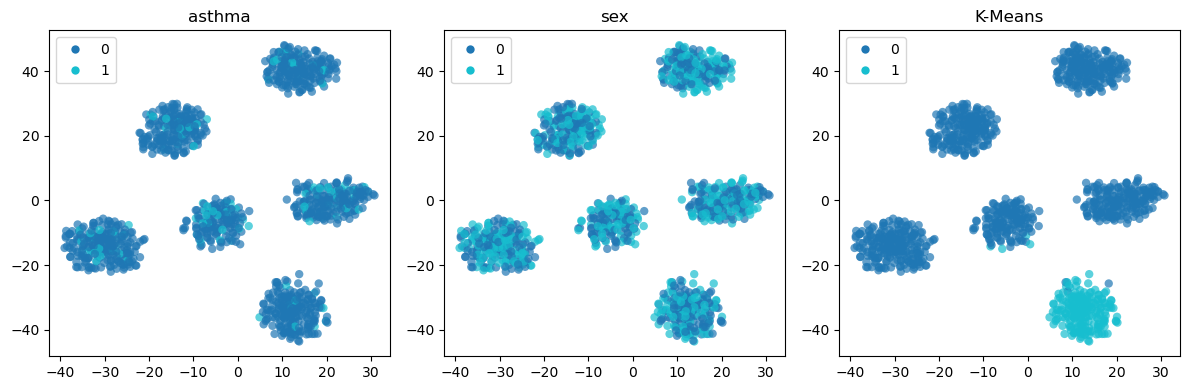

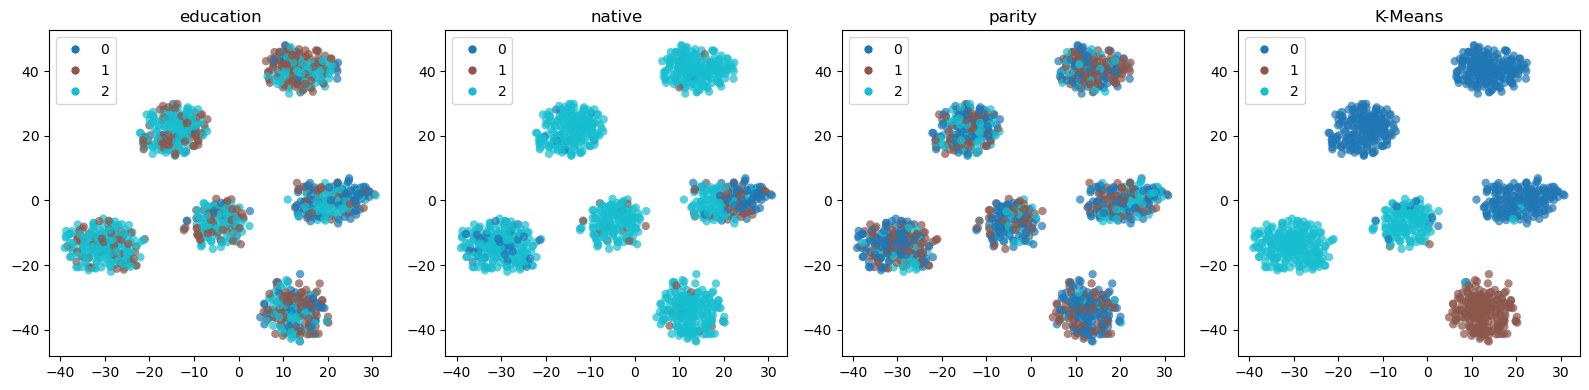

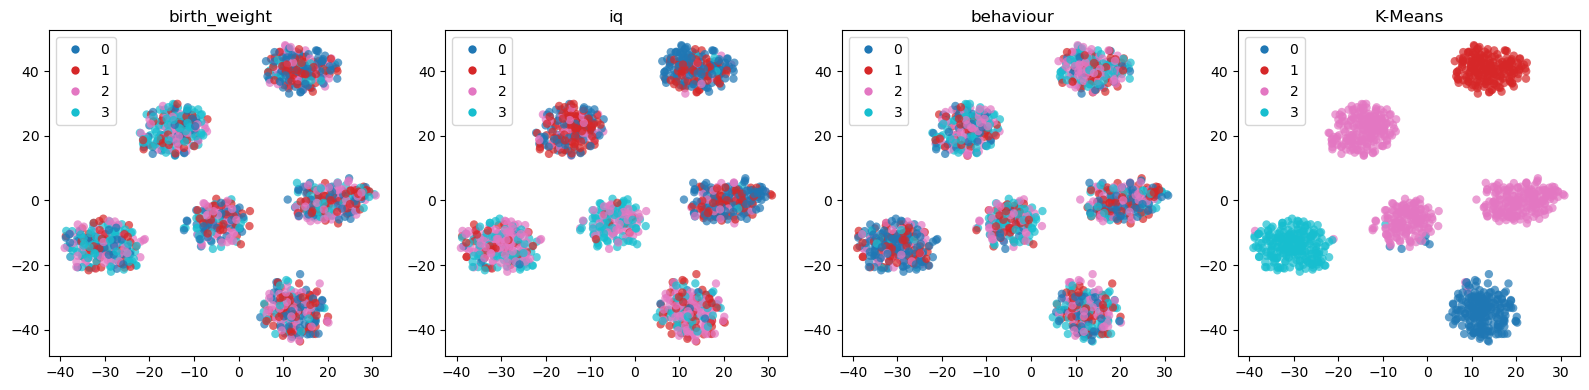

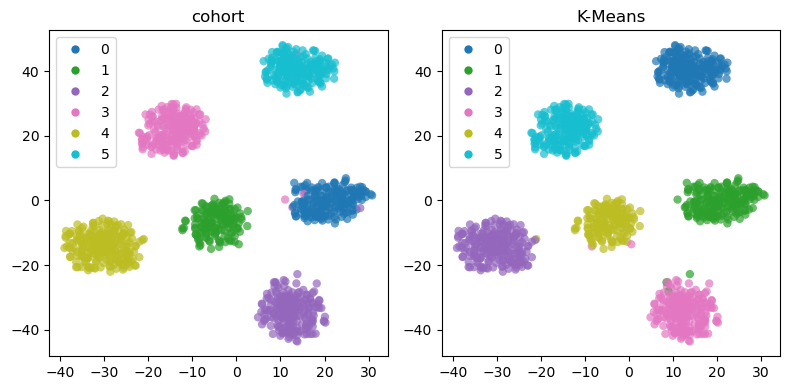

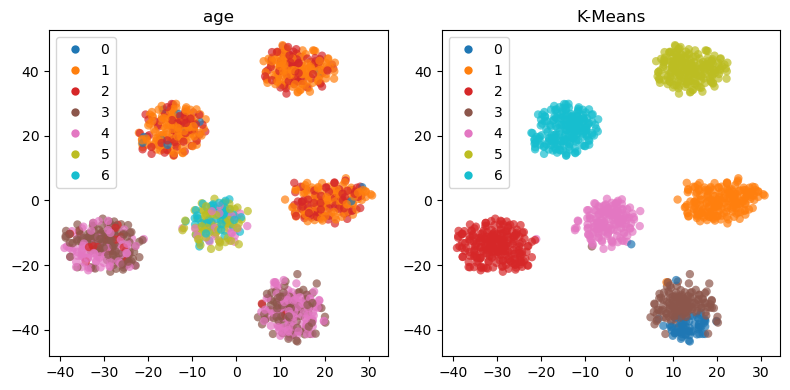

In [12]:
rl_method = "Raw data"
clust_method = "K-Means"
data = exposome
tsne_data = raw_data_tsne

for k in categorical_variables.keys():
    # Compute cluster assignments
    kmeans = KMeans(n_clusters=k, n_init=30)
    cluster_labels_ = kmeans.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})

    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

## GMM

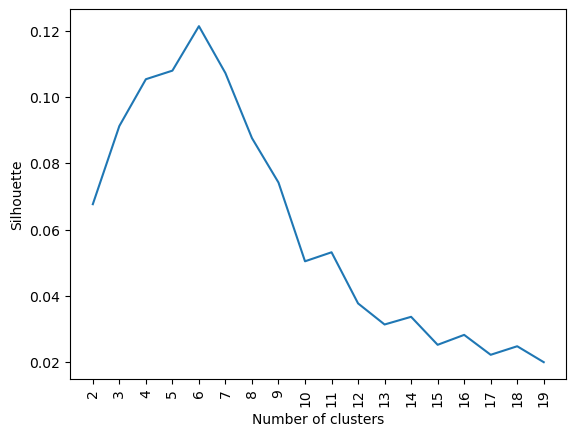

In [13]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    labels = gmm.fit_predict(exposome)
    sils.append(sklearn.metrics.silhouette_score(exposome, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.068']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.068']
education ['Acc: 0.526', 'ARI: 0.052', 'AMI: 0.020', 'Sil: 0.091']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.091']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.091']
birth_weight ['Acc: 0.326', 'ARI: 0.017', 'AMI: 0.026', 'Sil: 0.105']
iq ['Acc: 0.470', 'ARI: 0.202', 'AMI: 0.260', 'Sil: 0.105']
behaviour ['Acc: 0.311', 'ARI: 0.011', 'AMI: 0.018', 'Sil: 0.105']
cohort ['Acc: 0.995', 'ARI: 0.987', 'AMI: 0.983', 'Sil: 0.121']
age ['Acc: 0.587', 'ARI: 0.479', 'AMI: 0.584', 'Sil: 0.107']


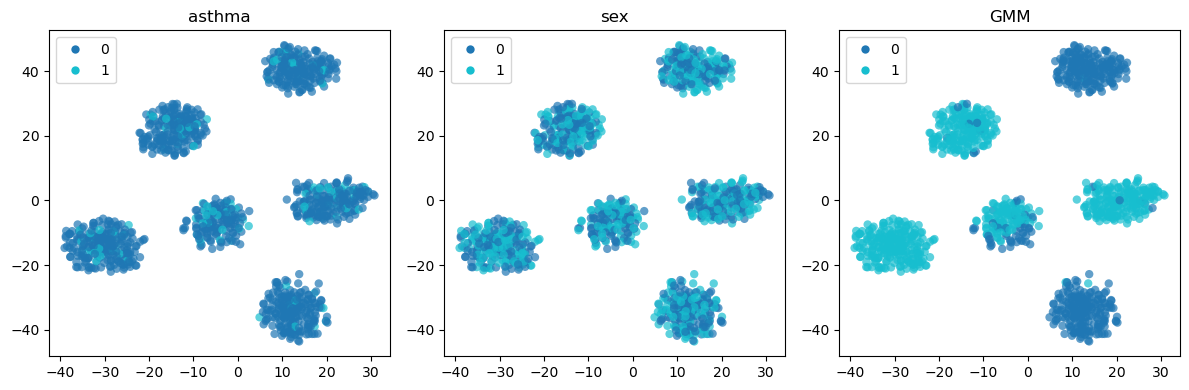

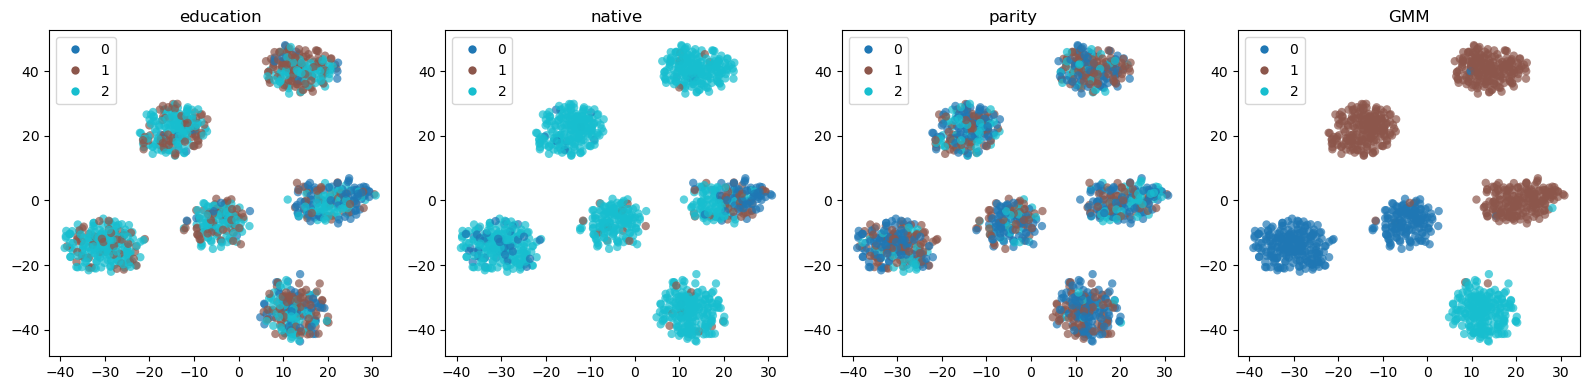

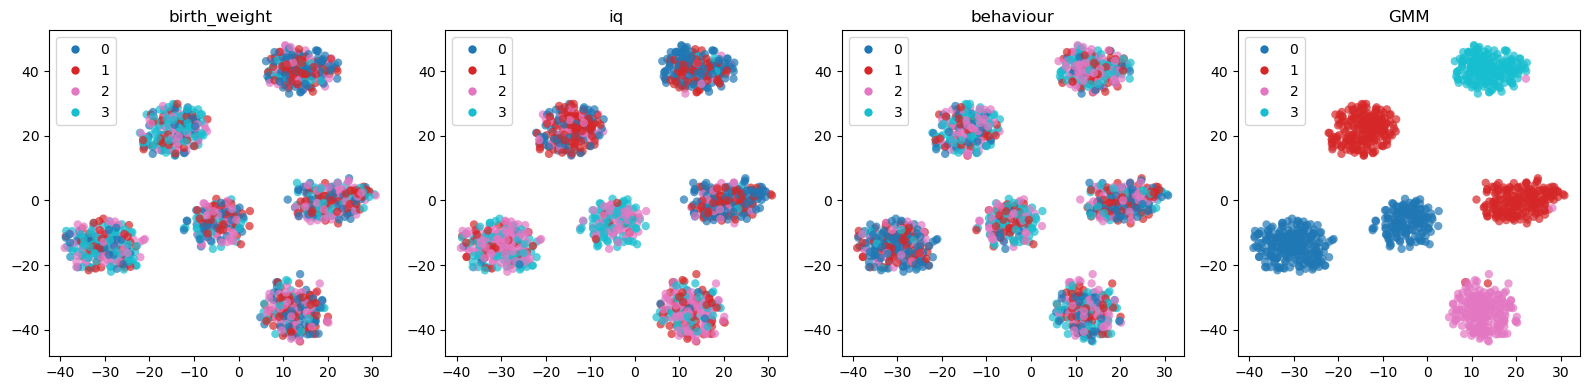

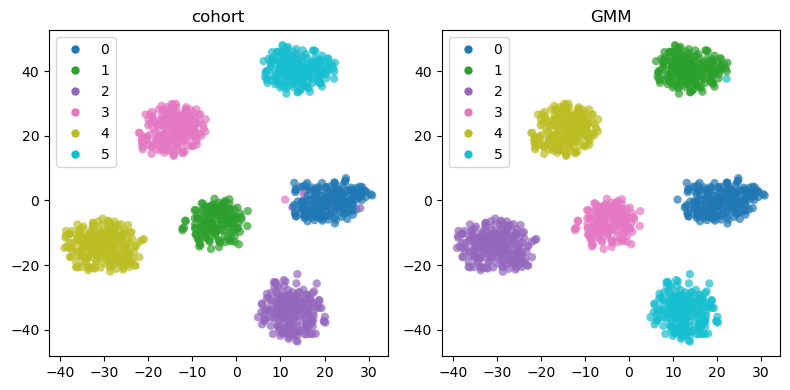

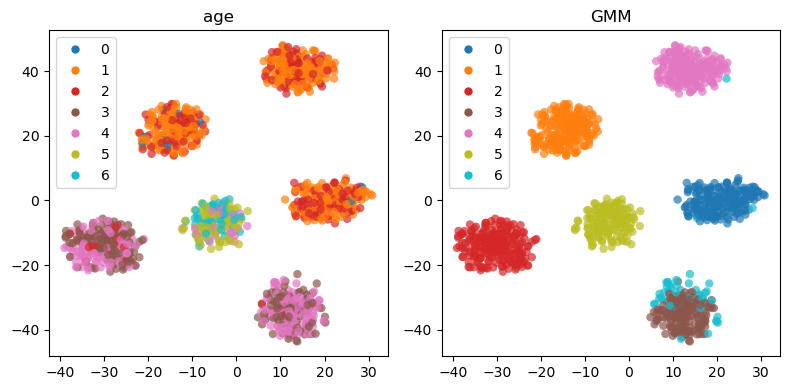

In [14]:
clust_method = "GMM"

for k in categorical_variables.keys():
    # Compute cluster assignments
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    cluster_labels_ = gmm.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable} 
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

## Agglomerative

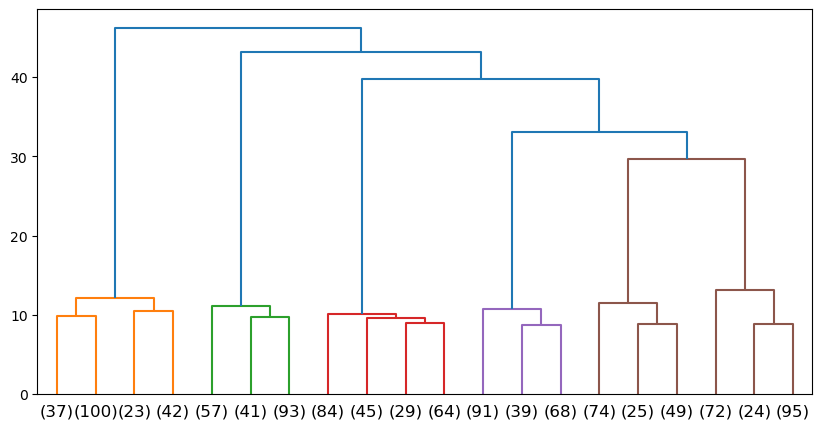

In [15]:
hier = hierarchy.linkage(exposome, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=hier, p=20, truncate_mode='lastp')
plt.show()

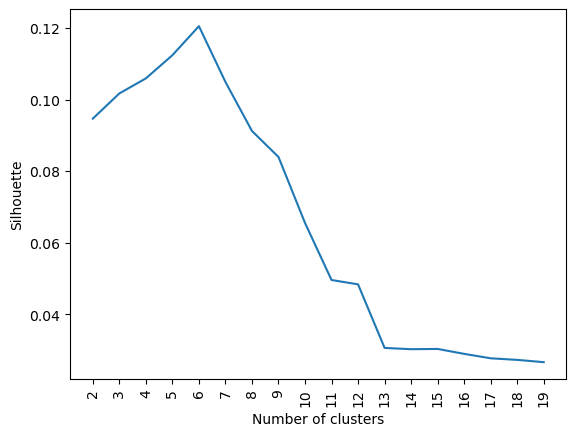

In [16]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(exposome, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.095']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.095']
education ['Acc: 0.558', 'ARI: 0.064', 'AMI: 0.033', 'Sil: 0.102']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.102']
parity ['Acc: 0.473', 'ARI: 0.008', 'AMI: 0.006', 'Sil: 0.102']
birth_weight ['Acc: 0.328', 'ARI: 0.018', 'AMI: 0.027', 'Sil: 0.106']
iq ['Acc: 0.430', 'ARI: 0.097', 'AMI: 0.141', 'Sil: 0.106']
behaviour ['Acc: 0.340', 'ARI: 0.025', 'AMI: 0.051', 'Sil: 0.106']
cohort ['Acc: 0.991', 'ARI: 0.980', 'AMI: 0.972', 'Sil: 0.121']
age ['Acc: 0.586', 'ARI: 0.478', 'AMI: 0.582', 'Sil: 0.105']


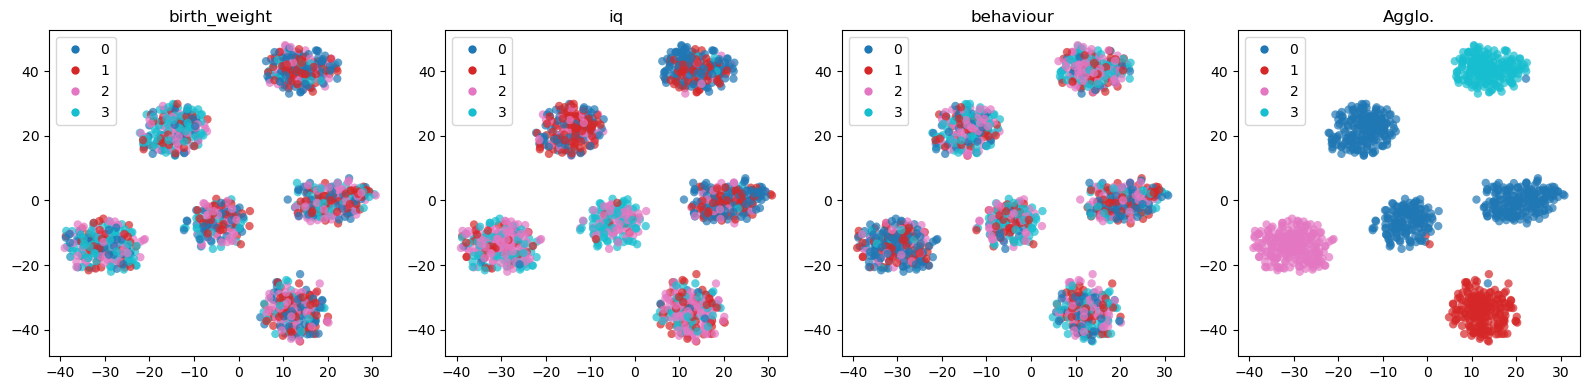

In [17]:
clust_method = "Agglo."

for k in categorical_variables.keys():
    # Compute cluster assignments
    cluster_labels_ = hierarchy.cut_tree(hier, n_clusters=k).squeeze()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(tsne_data, labels)

# PCA

In [18]:
# Find the number of PCs to explain 0.8 of the variance:
pca = PCA(n_components=0.8)
pca.fit(exposome)

z_pca = pca.transform(exposome)

# Number of PCs:
pca.n_components_

48

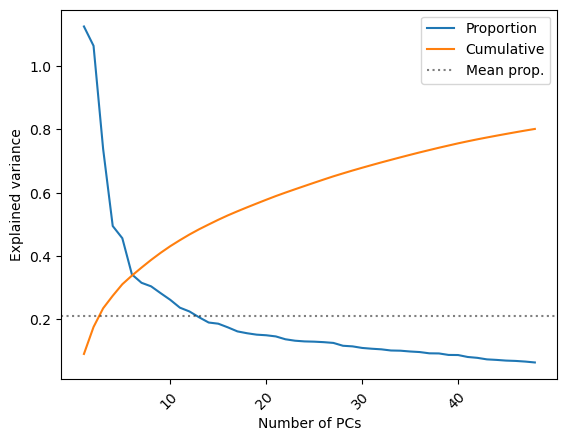

In [19]:
plt.plot(np.arange(0, pca.n_components_), pca.explained_variance_, label="Proportion")
plt.plot(np.arange(0, pca.n_components_), np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
plt.axhline(y = np.mean(pca.explained_variance_), color='black', linestyle='dotted', alpha=0.5, label="Mean prop.")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance');
plt.legend();

## K-means

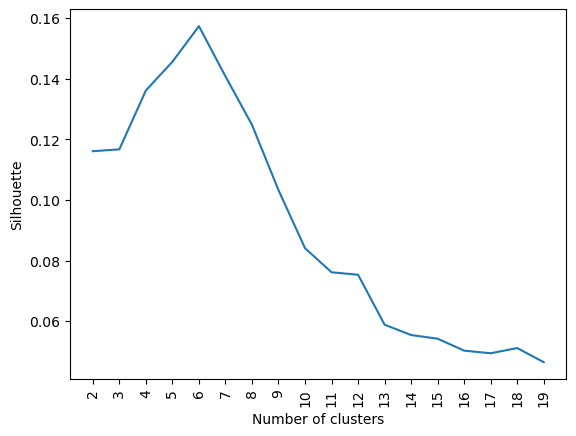

In [20]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [21]:
tsne = TSNE(n_components=2, init='pca')
z_pca_tsne = tsne.fit_transform(z_pca)

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.116']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.116']
education ['Acc: 0.525', 'ARI: 0.051', 'AMI: 0.019', 'Sil: 0.117']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.117']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.117']
birth_weight ['Acc: 0.328', 'ARI: 0.018', 'AMI: 0.026', 'Sil: 0.136']
iq ['Acc: 0.430', 'ARI: 0.098', 'AMI: 0.143', 'Sil: 0.136']
behaviour ['Acc: 0.339', 'ARI: 0.025', 'AMI: 0.051', 'Sil: 0.136']
cohort ['Acc: 0.990', 'ARI: 0.978', 'AMI: 0.971', 'Sil: 0.157']
age ['Acc: 0.584', 'ARI: 0.470', 'AMI: 0.567', 'Sil: 0.141']


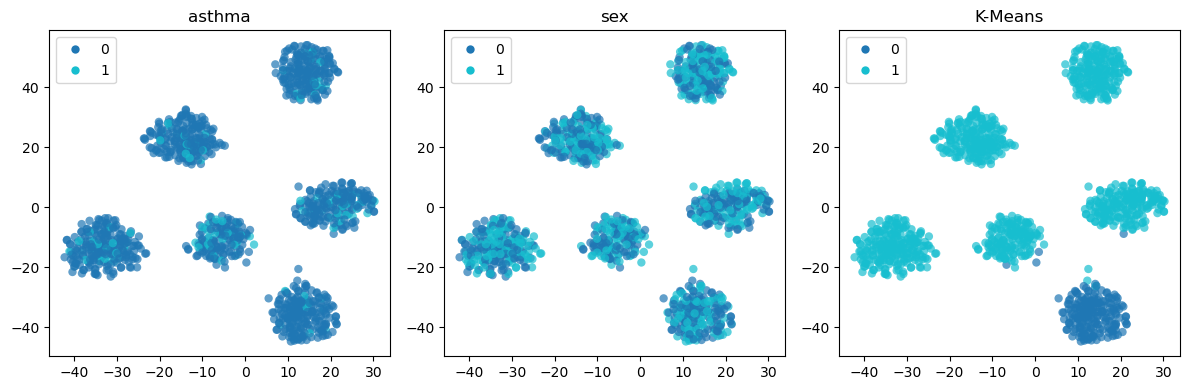

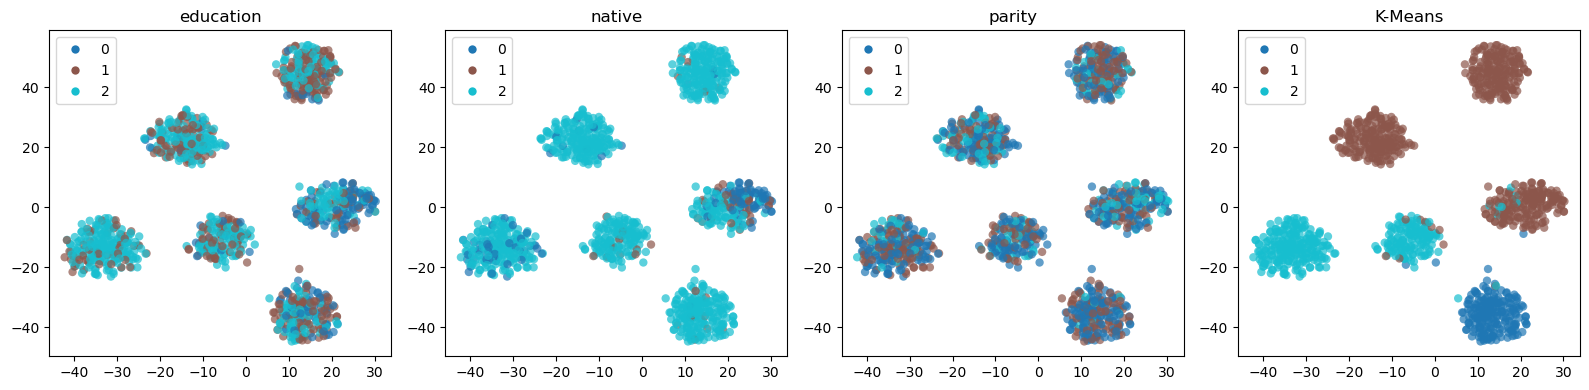

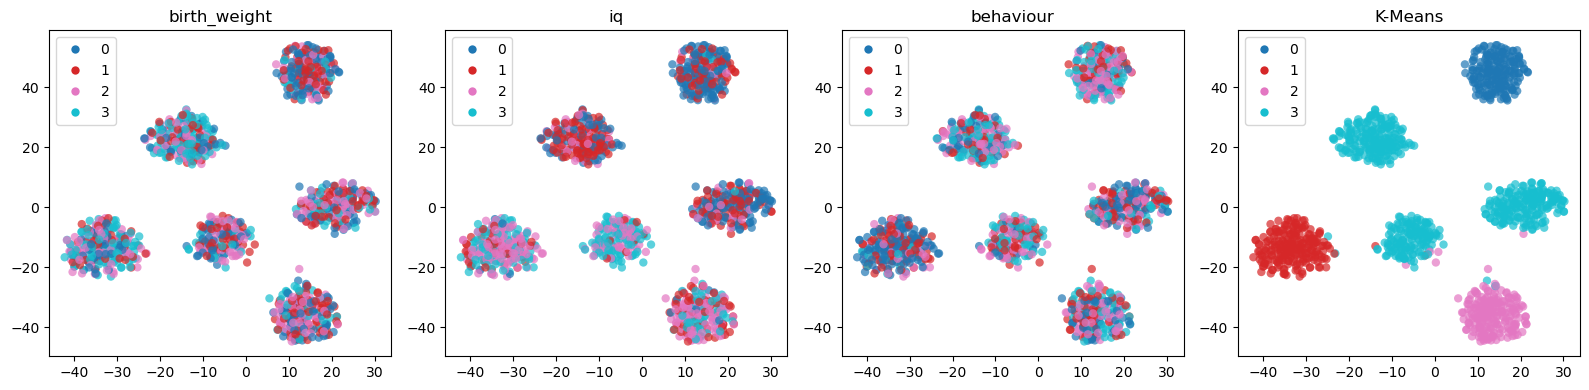

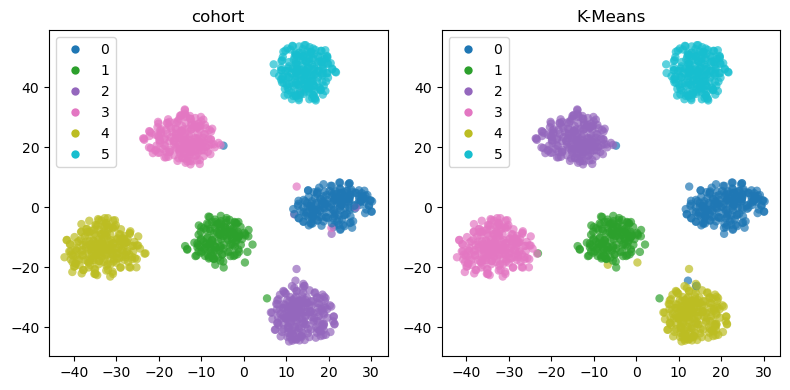

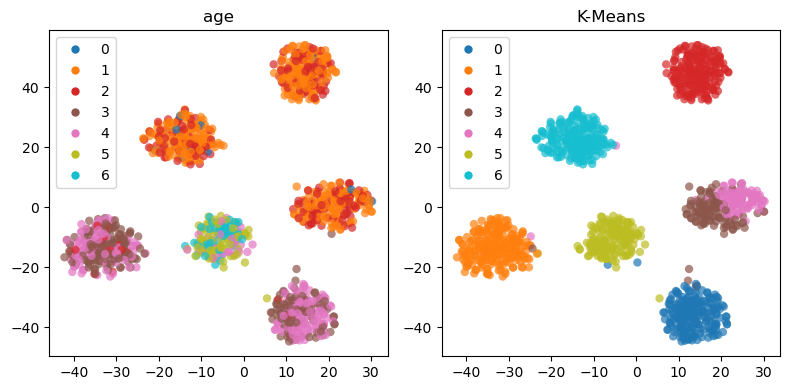

In [22]:
rl_method = "PCA"
clust_method = "K-Means"
data = z_pca
tsne_data = z_pca_tsne

for k in categorical_variables.keys():
    # Compute cluster assignments
    kmeans = KMeans(n_clusters=k, n_init=30)
    cluster_labels_ = kmeans.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(z_pca_tsne, labels)

## GMM

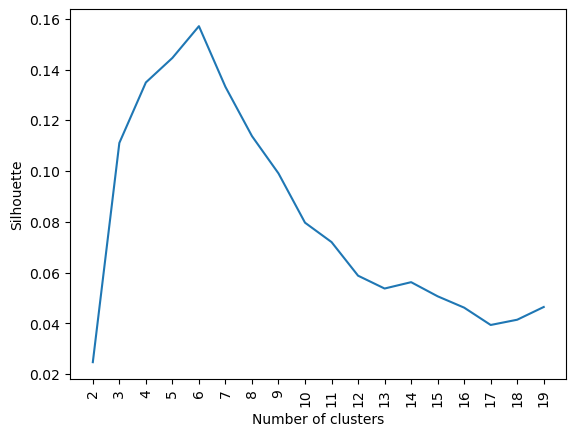

In [23]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    labels = gmm.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.054']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.054']
education ['Acc: 0.543', 'ARI: 0.015', 'AMI: 0.033', 'Sil: 0.092']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.092']
parity ['Acc: 0.475', 'ARI: 0.009', 'AMI: 0.006', 'Sil: 0.092']
birth_weight ['Acc: 0.324', 'ARI: 0.016', 'AMI: 0.025', 'Sil: 0.135']
iq ['Acc: 0.429', 'ARI: 0.094', 'AMI: 0.140', 'Sil: 0.135']
behaviour ['Acc: 0.337', 'ARI: 0.023', 'AMI: 0.050', 'Sil: 0.135']
cohort ['Acc: 0.987', 'ARI: 0.970', 'AMI: 0.961', 'Sil: 0.157']
age ['Acc: 0.584', 'ARI: 0.474', 'AMI: 0.565', 'Sil: 0.133']


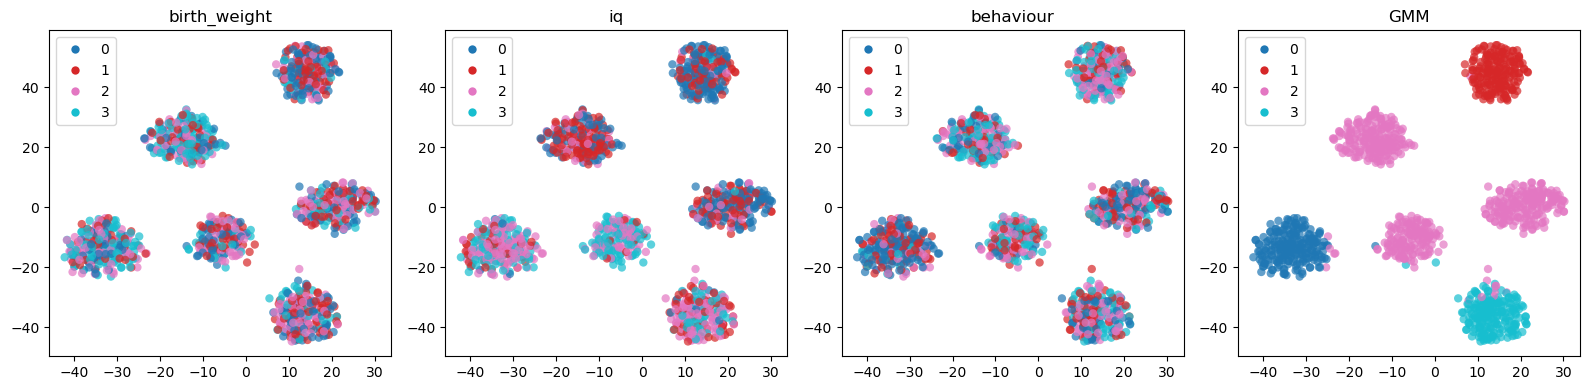

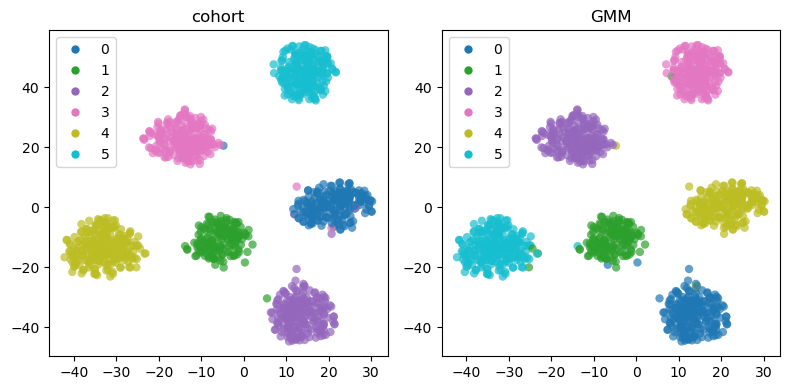

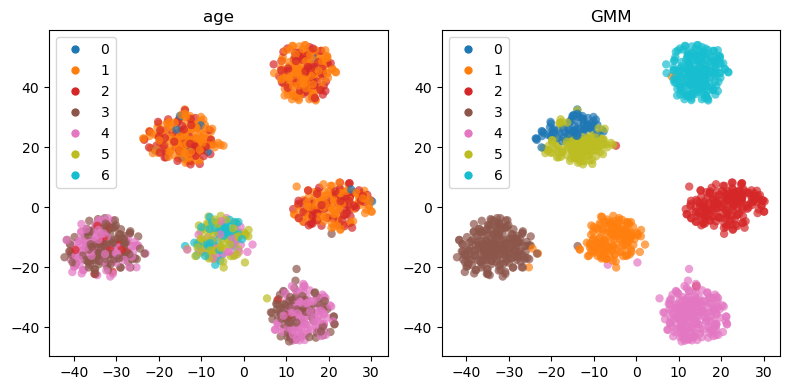

In [24]:
clust_method = "GMM"

for k in categorical_variables.keys():
    # Compute cluster assignments
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=30)
    cluster_labels_ = gmm.fit_predict(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(z_pca_tsne, labels)

## Agglomerative

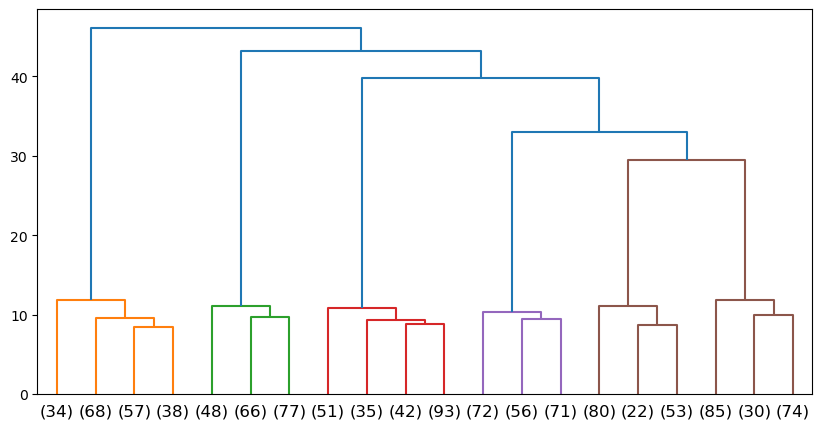

In [25]:
pca_hier = hierarchy.linkage(z_pca, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=pca_hier, p=20, truncate_mode='lastp')
plt.show()

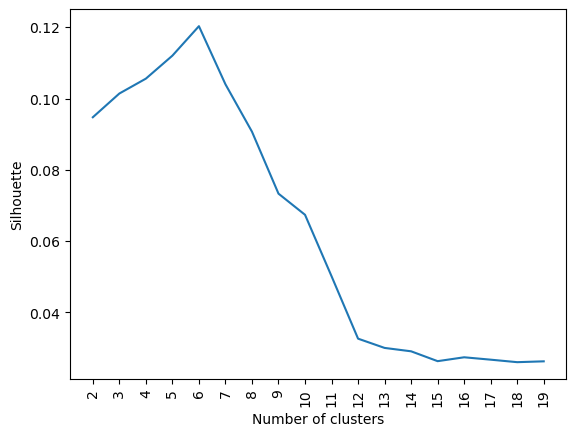

In [26]:
ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(pca_hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(exposome, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.116']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.116']
education ['Acc: 0.559', 'ARI: 0.063', 'AMI: 0.033', 'Sil: 0.126']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.126']
parity ['Acc: 0.473', 'ARI: 0.008', 'AMI: 0.006', 'Sil: 0.126']
birth_weight ['Acc: 0.327', 'ARI: 0.018', 'AMI: 0.027', 'Sil: 0.135']
iq ['Acc: 0.431', 'ARI: 0.096', 'AMI: 0.140', 'Sil: 0.135']
behaviour ['Acc: 0.340', 'ARI: 0.025', 'AMI: 0.051', 'Sil: 0.135']
cohort ['Acc: 0.987', 'ARI: 0.970', 'AMI: 0.960', 'Sil: 0.156']
age ['Acc: 0.584', 'ARI: 0.475', 'AMI: 0.577', 'Sil: 0.137']


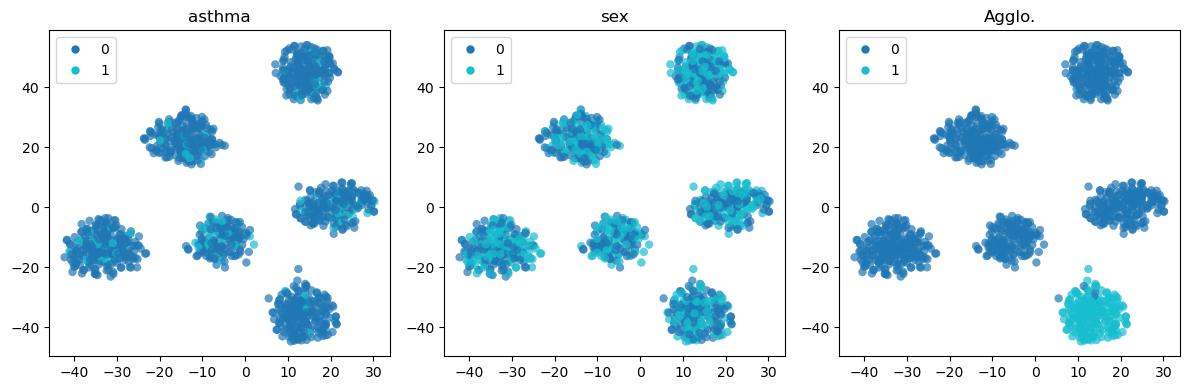

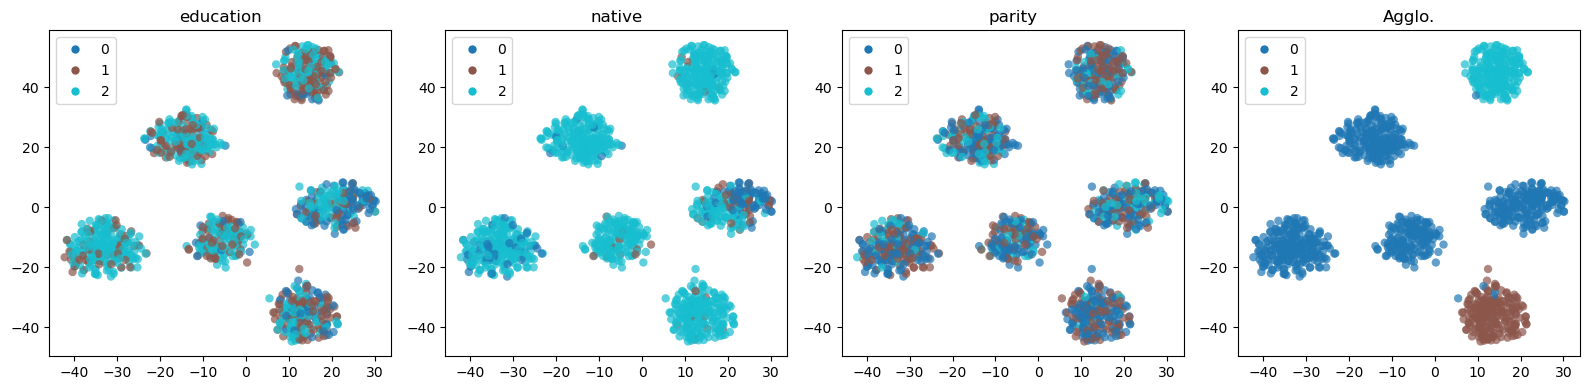

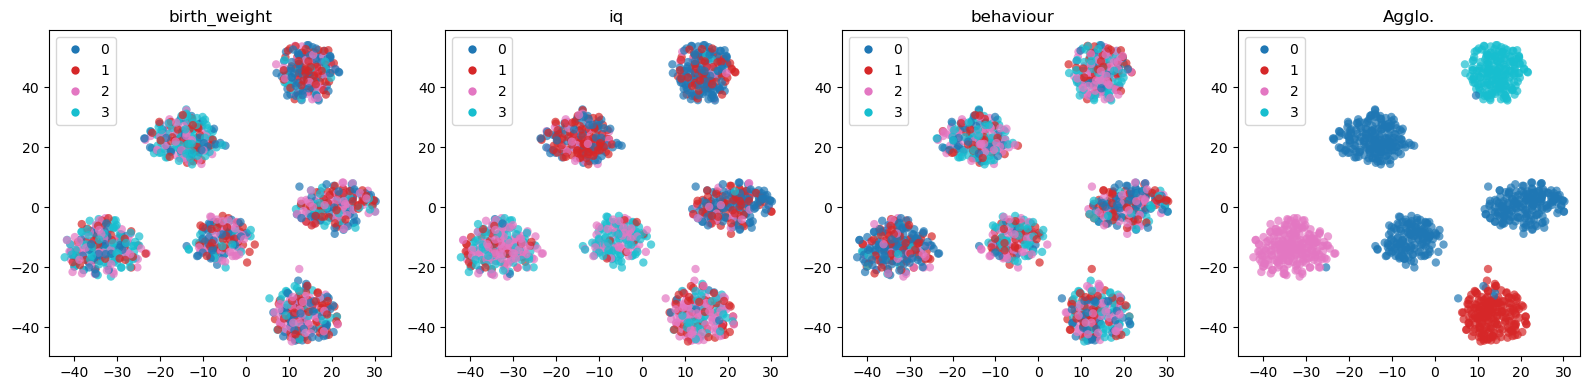

In [27]:
clust_method = "Agglo."

for k in categorical_variables.keys():
    # Compute cluster assignments
    cluster_labels_ = hierarchy.cut_tree(pca_hier, n_clusters=k).squeeze()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": cluster_labels_})
    # Compute metrics
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(data, labels, cluster_labels_, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)

    # Draw scatterplots
    labels = true_labels[k].copy()
    labels.update({clust_method: cluster_labels_})
    draw_multiple_labels(z_pca_tsne, labels)

# Results

## Metrics

In [28]:
results = pd.DataFrame(results)
# Save the ametrics on a CSV file
results.to_csv("results/metrics_classic.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

In [29]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

The results show that there is a strong batch effect on the exposome data. All the clustering methods group together the points from the same cohort.

Also, there seems to be a high correlation between cohort and age classes. Cohorts 0, 5 and 3 have mostly points for ages 0, 1 and 2, cohorts 2 and 4 have points for ages 3 and 4, and cohort 5 has points for ages 5 and 6.

It good be a good idea to try and correct for this batch effect both on the exposome and metabolomic data, then explore the clustering methods again.

## Compare assignments

In [30]:
labels = pd.DataFrame([d['labels'] for d in cluster_labels])
methods = pd.DataFrame(cluster_labels).loc[:,('rl_method', 'clust_method', 'n_clusters')]
cluster_labels_df = pd.concat((methods, labels), axis=1)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels_df).to_csv("results/assign_classic.csv", index=False)

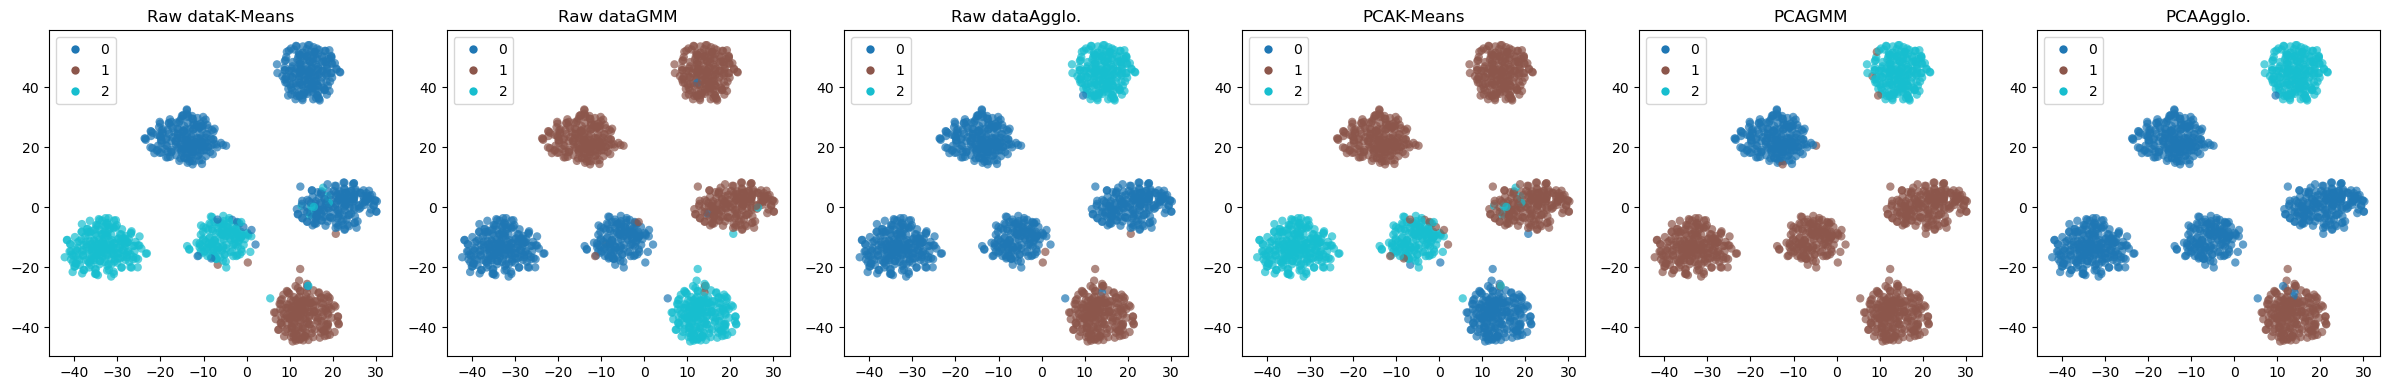

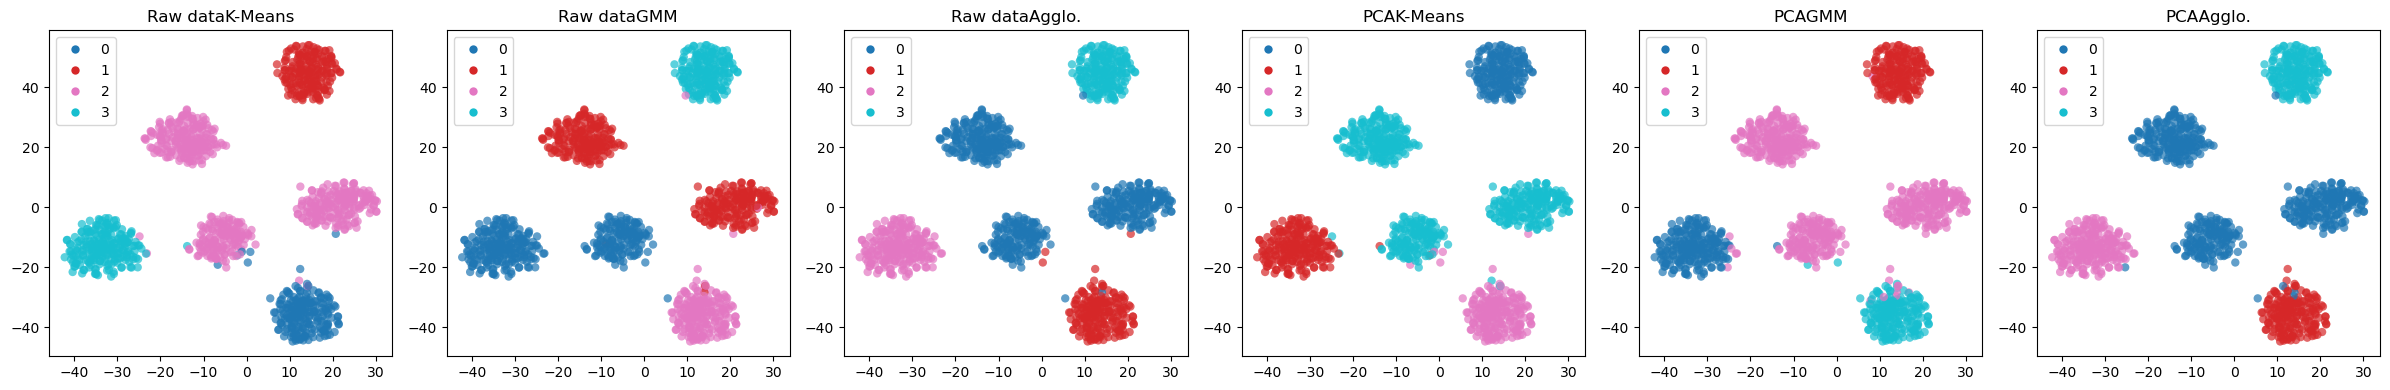

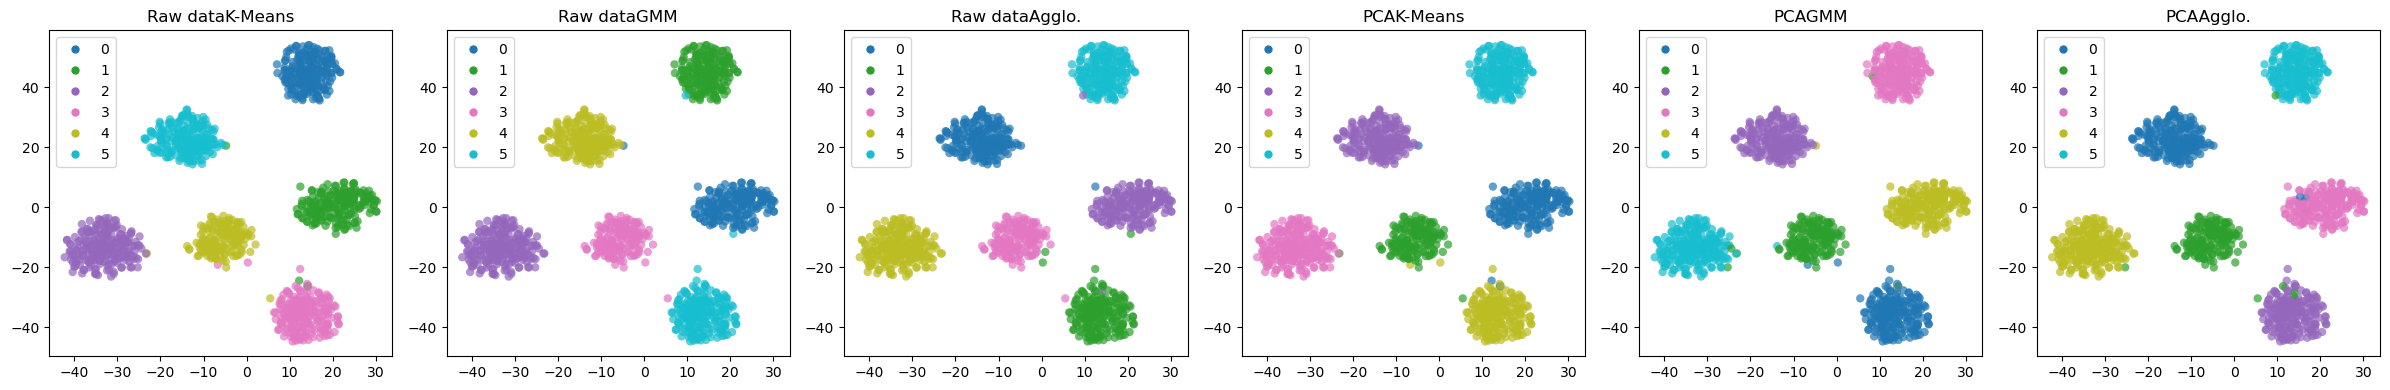

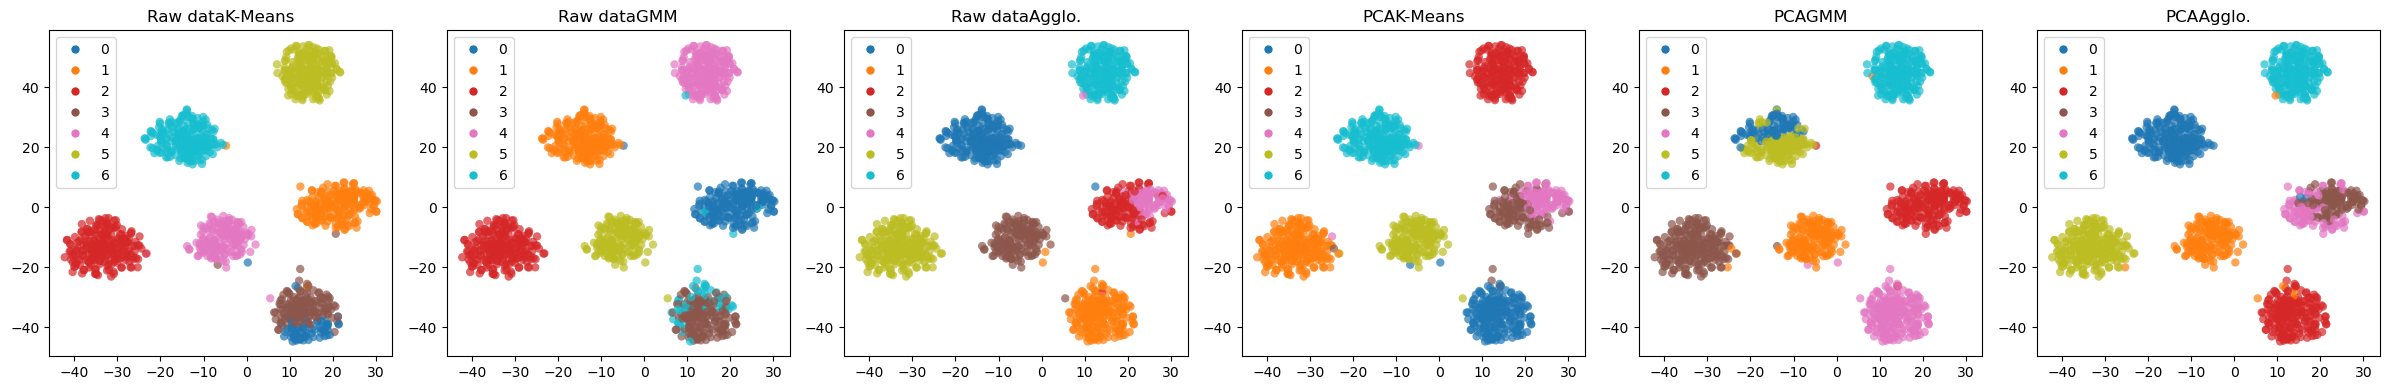

In [31]:
cluster_labels = pd.DataFrame(cluster_labels)
for k in categorical_variables.keys():
    clusters = cluster_labels[cluster_labels.n_clusters==k]
    labels = {clusters.rl_method[i] + clusters.clust_method[i]: clusters.labels[i] for i in clusters.index}
    draw_multiple_labels(z_pca_tsne, labels, max_cols=6)

There seems to be a lot of overlaping between the found clusters with the different methods, specially for K=5, where the clusters match the cohort classes almost perfectly.